In [26]:
import torch
import matplotlib.pyplot as plt
from qadence import feature_map, hea, chain, add, Z
from qadence import QNN, QuantumCircuit
from qadence.types import BasisSet, ReuploadScaling
from torch.optim.lr_scheduler import ReduceLROnPlateau



The differential equation we're solving: du/dx + λu(κ + tan(λx)) = 0 with boundary condition u(0) = u0. The exact solution is: u(x) = u0 * exp(-κλx) * cos(λx)

In [27]:

class ScaledQNN(QNN):
    def __init__(self, circuit, observable, inputs, scale_factor=3.0):
        super().__init__(circuit=circuit, observable=observable, inputs=inputs)
        # Scale factor multiplies the output to expand the range
        self.scale_factor = scale_factor
        
    def forward(self, x):
    
        return super().forward(x) * self.scale_factor



Custom QNN class that extends base QNN to include output scaling. This is necessary because quantum measurements are bounded by [-1,1], but our differential equation solution might need a larger range.Forward pass through the quantum circuit with scaling. Args: x: Input tensor Returns: Scaled quantum measurement values

In [28]:
def create_model(scale_factor=3.0):
    n_qubits = 4
    depth = 4
    
    fm = feature_map(
        n_qubits=n_qubits,
        param="x",          #
        fm_type=BasisSet.CHEBYSHEV,  
        reupload_scaling=ReuploadScaling.TOWER
    )
    
    ansatz = hea(n_qubits=n_qubits, depth=depth)
    observable = add(Z(i) for i in range(n_qubits))
    circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
    
    return ScaledQNN(circuit=circuit, observable=observable, 
                    inputs=["x"], scale_factor=scale_factor)



 Creates a Quantum Neural Network model for solving the DE. The architecture consists of:
    1. Chebyshev feature map: Encodes classical inputs into quantum states
       using Chebyshev polynomials for better expressivity
    2. Hardware-efficient ansatz: Trainable quantum circuit
    3. Observable measurement: Converts quantum state back to classical output
    
Args: scale_factor: Multiplier for the output range, Returns:ScaledQNN: Quantum model ready for training

In [29]:
def train_model(model, λ, κ, u0, n_epochs=400, n_points=20):

    xmin, xmax = -0.99, 0.99
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = torch.nn.MSELoss()
    
    def calc_loss(x_batch):
        model_output = model(x_batch)
        deriv_model = torch.autograd.grad(
            outputs=model_output,
            inputs=x_batch,
            grad_outputs=torch.ones_like(model_output),
            create_graph=True  
        )[0]

        deriv_exact = -λ * model_output * (κ + torch.tan(λ * x_batch))
        return criterion(deriv_model, deriv_exact)
    
    for epoch in range(n_epochs):
        x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad=True)).unsqueeze(1)
        
        optimizer.zero_grad()
        ode_loss = calc_loss(x_train)
        
        x_boundary = torch.tensor([[0.0]], requires_grad=True)
        boundary_loss = 5.0 * criterion(model(x_boundary), torch.tensor([[u0]]))
        
        total_loss = ode_loss + boundary_loss
        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")
    
    return model


Trains the QNN to solve the differential equation using gradient descent.
    
The training process:
1. Generates random points in the domain
2. Computes model derivatives using autograd
3. Compares with the differential equation
4. Enforces boundary condition
5. Updates parameters using Adam optimizer
    
Args:
    model: The quantum neural network
    λ, κ: Differential equation parameters
    u0: Initial condition value
    n_epochs: Number of training iterations
    n_points: Number of training points per batch
    
Returns:
 model: Trained quantum model


 The loss function alculates the loss term for the differential equation.
        
Computes:
1. Model output u(x)
2. Numerical derivative du/dx
3. Compares with the DE: du/dx = -λu(κ + tan(λx))
    
  

In [30]:
def plot_results(model, λ, κ, u0):

    x_test = torch.arange(-0.99, 0.99, step=0.01).unsqueeze(1)
    pred = model(x_test).detach()
    exact = u0 * torch.exp(-κ*λ*x_test) * torch.cos(λ*x_test)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x_test, exact, 'b-', label='Exact')
    plt.plot(x_test, pred, 'r--', label='QNN')
    plt.title(f'DE Solution: λ={λ}, κ={κ}, u₀={u0}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.semilogy(x_test, torch.abs(pred - exact), 'k-', label='Error')
    plt.xlabel('x')
    plt.ylabel('|Error|')
    plt.legend()
    plt.grid(True)
    plt.show()


Plots graphs of both the predicted and real DE

Epoch 0, Loss: 495.847196
Epoch 50, Loss: 0.476894
Epoch 100, Loss: 0.100662
Epoch 150, Loss: 0.011267
Epoch 200, Loss: 0.015166
Epoch 250, Loss: 0.016125
Epoch 300, Loss: 0.016323
Epoch 350, Loss: 0.018058


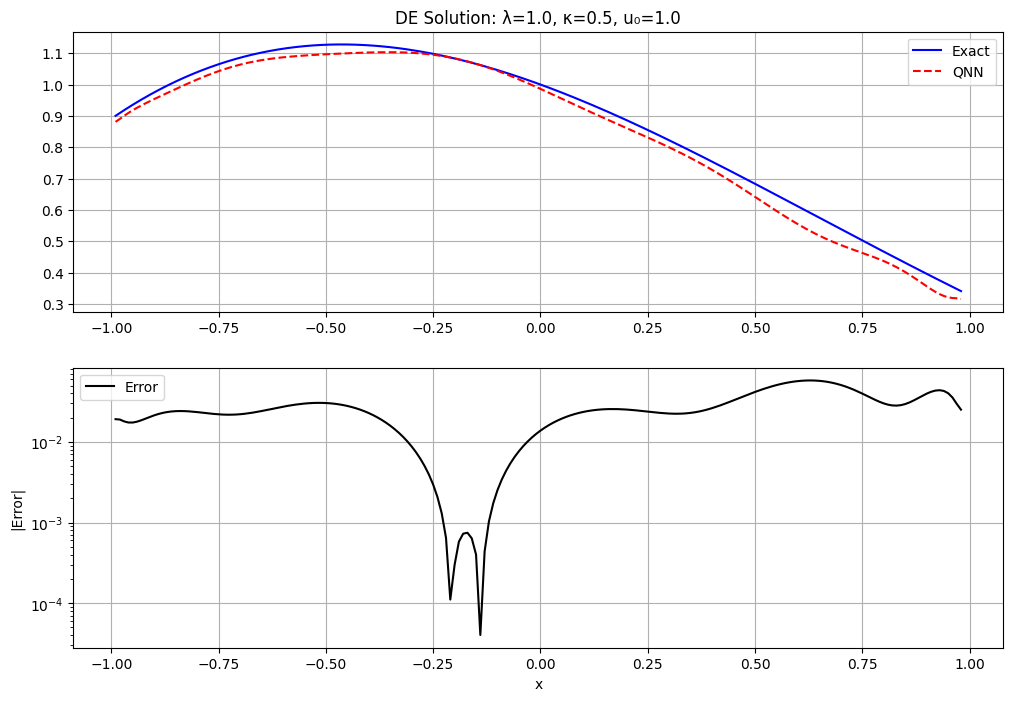

In [31]:
λ, κ, u0 = 1.0, 0.5, 1.0
model = create_model()
trained_model = train_model(model, λ, κ, u0)
plot_results(trained_model, λ, κ, u0)

Import stuff

In [32]:
import torch
import matplotlib.pyplot as plt
from qadence import (
    feature_map, hea, chain, QNN, QuantumCircuit,
    Z, add
)
from qadence.types import BasisSet, ReuploadScaling
import numpy as np
from scipy.integrate import solve_ivp



Calculate the derivative according to the equation
    du/dx = 4u - 6u^2 + sin(50x) + ucos(25x) - 1/2

In [33]:
def dfdx_equation(x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
    return (4*u - 6*u**2 + torch.sin(50*x) + u*torch.cos(25*x) - 0.5)

def de_system(x, u):
    return [4*u - 6*u**2 + np.sin(50*x) + u*np.cos(25*x) - 0.5]

def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(inputs),
        create_graph=True,
        retain_graph=True,
    )[0]
    return grad



Define the loss function

In [34]:
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor, u0: float = 0.75) -> torch.Tensor:
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    rhs = dfdx_equation(inputs, model_output)
    ode_loss = criterion(deriv_model, rhs)
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[u0]])
    boundary_loss = 10.0 * criterion(boundary_model, boundary_exact)  

    return ode_loss + boundary_loss



Create QNN model

In [35]:
def create_qnn_model(n_qubits: int = 5, depth: int = 5): 
    fm = feature_map(
        n_qubits=n_qubits,
        param="x",
        fm_type=BasisSet.CHEBYSHEV,
        reupload_scaling=ReuploadScaling.TOWER,
    )

    ansatz = hea(n_qubits=n_qubits, depth=depth)

    observable = add(Z(i) for i in range(n_qubits))

    circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
    model = QNN(circuit=circuit, observable=observable, inputs=["x"])
    
    return model



Training function

In [36]:
def train_model(model, n_epochs=500, n_points=100, lr=0.05, u0=0.75): 
    xmin, xmax = -0.99, 0.99
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad=True)).unsqueeze(1)
        
        loss = loss_fn(model=model, inputs=x_train, u0=u0)
        loss.backward()
        optimizer.step()
        
        scheduler.step(loss)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        losses.append(loss.item())
    
    return losses



Create and train model

In [37]:
n_qubits = 5  
depth = 5     
u0 = 0.75     

model = create_qnn_model(n_qubits=n_qubits, depth=depth)
losses = train_model(model, n_epochs=500, n_points=100, lr=0.05, u0=u0)



Epoch 0, Loss: 5.9078
Epoch 50, Loss: 0.9558
Epoch 100, Loss: 0.9262
Epoch 150, Loss: 0.8295
Epoch 200, Loss: 0.7388
Epoch 250, Loss: 0.6823
Epoch 300, Loss: 0.7803
Epoch 350, Loss: 0.6596
Epoch 400, Loss: 0.7854
Epoch 450, Loss: 0.8113


Generate numerical solution

In [38]:
x_span = (-0.99, 0.99)
x_eval = np.linspace(x_span[0], x_span[1], 200)
numerical_solution = solve_ivp(
    de_system,
    x_span,
    [u0],
    t_eval=x_eval,
    method='RK45',
    rtol=1e-8,
    atol=1e-8
)

Plot results

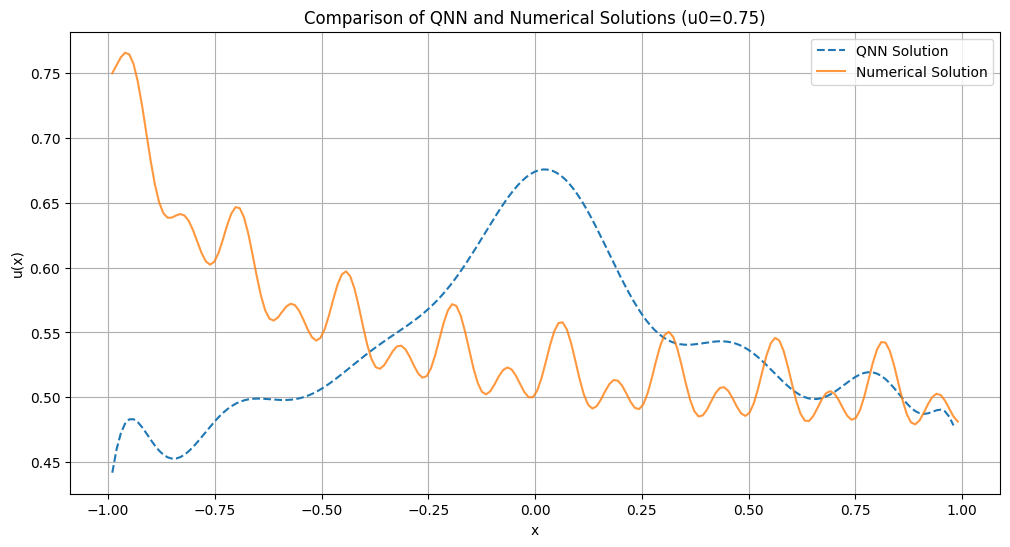

In [39]:
x_test = torch.arange(-0.99, 0.99, step=0.01).unsqueeze(1)
result_model = model(x_test).flatten().detach()

plt.figure(figsize=(12, 6))
plt.plot(x_test, result_model, label='QNN Solution', linestyle='--')
plt.plot(numerical_solution.t, numerical_solution.y[0], label='Numerical Solution', alpha=0.8)
plt.title(f'Comparison of QNN and Numerical Solutions (u0={u0})')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)